In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [5]:
df = pd.read_csv('../data/clean_reclean/time_series.csv')  # Ajuste le chemin si besoin

# Création de la colonne datetime
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')

# Agrégation mensuelle
monthly_avg = df.groupby('Date')['SalePrice'].median().reset_index()
monthly_avg.columns = ['Date', 'AverageSalePrice']

# Mise en index datetime
monthly_avg.set_index('Date', inplace=True)
monthly_avg.index.name = 'Date'

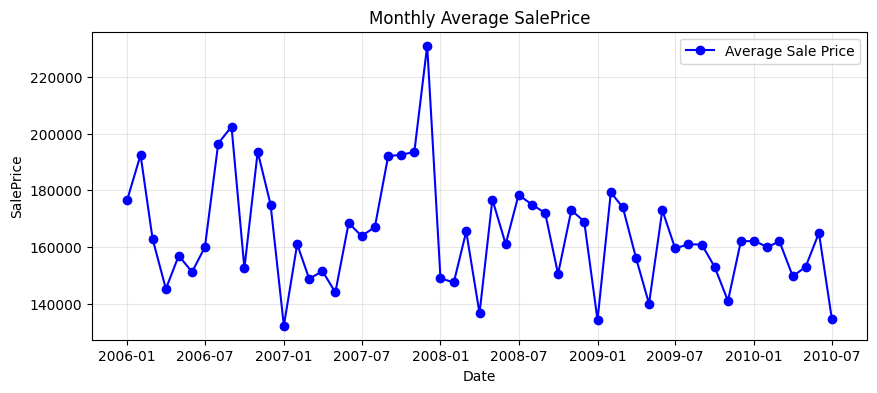

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg, label='Average Sale Price', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('Monthly Average SalePrice')
plt.xlabel('Date')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

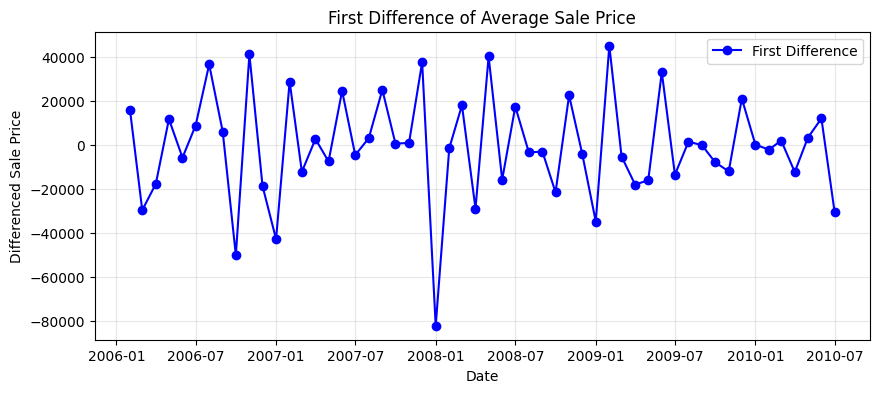

In [7]:
monthly_diff = monthly_avg['AverageSalePrice'].diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(monthly_diff, label='First Difference', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('First Difference of Average Sale Price')
plt.xlabel('Date')
plt.ylabel('Differenced Sale Price')
plt.legend()
plt.show()

In [8]:
X_orig = np.arange(len(monthly_avg)).reshape(-1, 1)
X_orig_const = sm.add_constant(X_orig)
y_orig = monthly_avg['AverageSalePrice'].values
model_orig = sm.OLS(y_orig, X_orig_const).fit()
original_p_values = model_orig.pvalues[1]
print(f"Original series trend p-value: {original_p_values:.4f}")

Original series trend p-value: 0.0660


In [9]:
log_avg = np.log(monthly_avg['AverageSalePrice'])
log_diff = log_avg.diff().dropna()

X_log_diff = np.arange(len(log_diff)).reshape(-1, 1)
X_log_diff_const = sm.add_constant(X_log_diff)
y_log_diff = log_diff.values
model_log_diff = sm.OLS(y_log_diff, X_log_diff_const).fit()
log_diff_p_value = model_log_diff.pvalues[1]
print(f"Log-differenced series trend p-value: {log_diff_p_value:.4f}")

Log-differenced series trend p-value: 0.8511


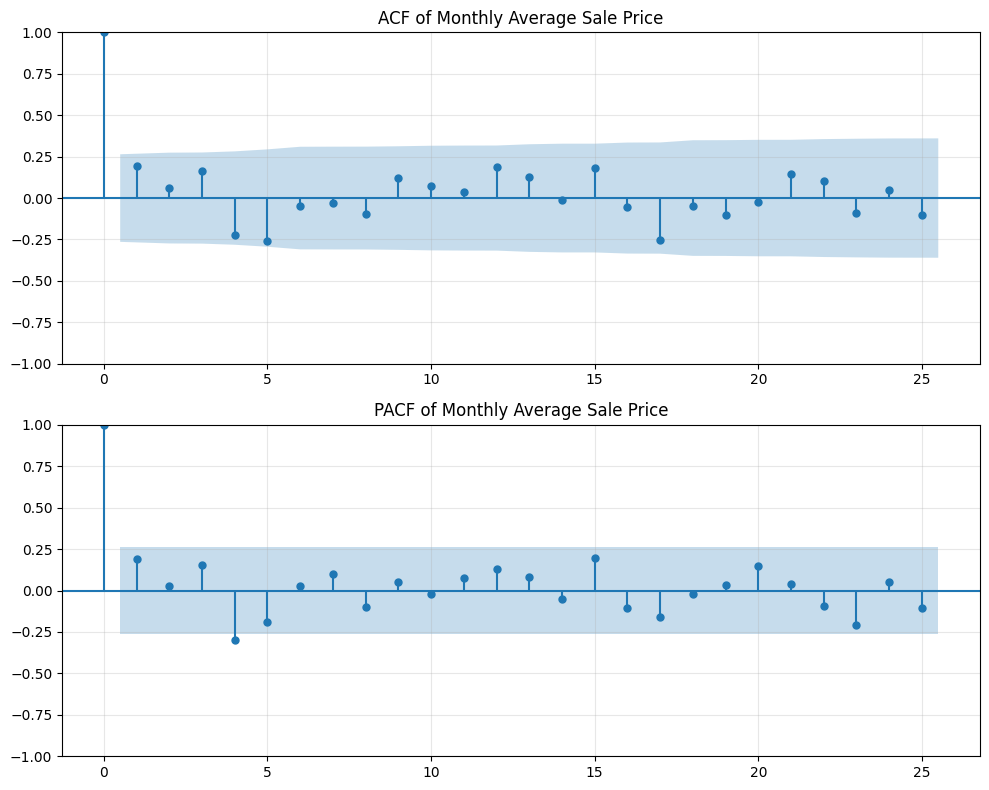

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(monthly_avg, lags=25, ax=axes[0])
axes[0].set_title('ACF of Monthly Average Sale Price')
axes[0].grid(True, alpha=0.3)

plot_pacf(monthly_avg, lags=25, ax=axes[1])
axes[1].set_title('PACF of Monthly Average Sale Price')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
print(monthly_avg)

            AverageSalePrice
Date                        
2006-01-01          176700.0
2006-02-01          192500.0
2006-03-01          162900.0
2006-04-01          145250.0
2006-05-01          156950.0
2006-06-01          151200.0
2006-07-01          160000.0
2006-08-01          196500.0
2006-09-01          202500.0
2006-10-01          152500.0
2006-11-01          193605.0
2006-12-01          175000.0
2007-01-01          132250.0
2007-02-01          161000.0
2007-03-01          148800.0
2007-04-01          151500.0
2007-05-01          144000.0
2007-06-01          168500.0
2007-07-01          163900.0
2007-08-01          167000.0
2007-09-01          192000.0
2007-10-01          192570.5
2007-11-01          193500.0
2007-12-01          231000.0
2008-01-01          149000.0
2008-02-01          147500.0
2008-03-01          165500.0
2008-04-01          136625.0
2008-05-01          176750.0
2008-06-01          161000.0
2008-07-01          178400.0
2008-08-01          175000.0
2008-09-01    

In [12]:
from pmdarima import auto_arima

model = auto_arima(
    monthly_avg,
    seasonal=True,
    m=12,  # Monthly data
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begi

                                  Model  Forecast Error Variance
0  ARIMA(0, 1, 0) x SARIMA(2, 1, 3, 12)             2.356888e+09
1  ARIMA(2, 1, 2) x SARIMA(2, 1, 4, 12)             2.427216e+09
2  ARIMA(0, 1, 0) x SARIMA(2, 1, 4, 12)             2.438028e+09
3  ARIMA(2, 1, 2) x SARIMA(2, 1, 3, 12)             2.749911e+14


ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

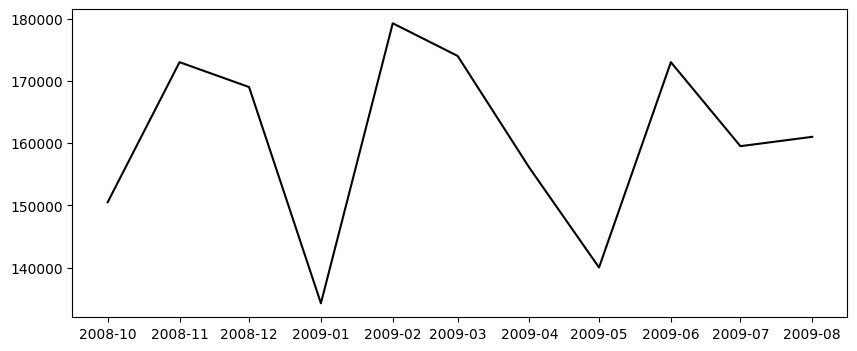

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Split dataset,
n = len(monthly_avg)
split = int(n * 0.8)  # 80% for training, 20% for testing
split2 = int(n * 0.6)  # 90% for training, 10% for testing
train = monthly_avg.iloc[:split2]+monthly_avg.iloc[split:]
test = monthly_avg.iloc[split2:split]

#Specify combinations,
non_seasonal_orders = [
    # (1,1,1),
    # (1,1,0),
    # (0,1,1),
    (0,1,0),
    (2,1,2),
    # (2,1,0),
    # (0,1,2),
    # (0,1,3),
    # (2,1,3),
    # (2,1,4),
    # (3,1,3),
    # (3,1,4)

]

seasonal_orders = [

    # (1,1,1,12),
    # (1,1,0,12),
    # (0,1,1,12),
    # (0,1,0,12),
    # (2,1,2,12),
    # (2,1,0,12),
    # (0,1,2,12),
    # (0,1,3,12),

    (2,1,3,12),
    (2,1,4,12),

    # (3,1,3,12),

]

# Dictionary to hold results,
results = {}

# Loop over combinations,
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        history = train.copy()

        for t in range(len(test)):
            model = SARIMAX(history,
                            order=ns_order,
                            seasonal_order=s_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)

            forecast = model.forecast(steps=1).iloc[0]
            actual = test['AverageSalePrice'].iloc[t]

            preds.append(forecast)
            actuals.append(actual)

            # Update history with actual
            history = pd.concat([history, test.iloc[[t]]])

        errors = np.array(actuals) - np.array(preds)
        var_error = np.var(errors)

        results[label] = {
            'Forecasts': preds,
            'Actuals': actuals,
            'Errors': errors,
            'Variance of Forecast Error': var_error
        }

# Create summary DataFrame and get best two models,
summary_df = pd.DataFrame([
    {'Model': name, 'Forecast Error Variance': res['Variance of Forecast Error']}
    for name, res in results.items()
]).sort_values('Forecast Error Variance').reset_index(drop=True)

print(summary_df)
# Plot only top 2 models,
for name in summary_df['Model'][:2]:
    res = results[name]
    # Ensure both x and y are numpy arrays of the same length
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/var/data/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begi

                                    Model  Forecast Error Variance
0    ARIMA(0, 1, 1) x SARIMA(2, 1, 0, 12)             2.639698e+08
1    ARIMA(2, 1, 4) x SARIMA(0, 1, 0, 12)             2.643658e+08
2    ARIMA(2, 1, 0) x SARIMA(0, 1, 2, 12)             2.810364e+08
3    ARIMA(0, 1, 1) x SARIMA(0, 1, 2, 12)             2.917130e+08
4    ARIMA(0, 1, 3) x SARIMA(0, 1, 0, 12)             2.952304e+08
..                                    ...                      ...
139  ARIMA(0, 1, 1) x SARIMA(0, 1, 1, 12)             6.643581e+16
140  ARIMA(3, 1, 3) x SARIMA(1, 1, 1, 12)             2.883274e+42
141  ARIMA(3, 1, 4) x SARIMA(1, 1, 1, 12)             4.256137e+46
142  ARIMA(3, 1, 3) x SARIMA(0, 1, 1, 12)             3.400323e+63
143  ARIMA(3, 1, 4) x SARIMA(0, 1, 1, 12)            4.861907e+224

[144 rows x 2 columns]


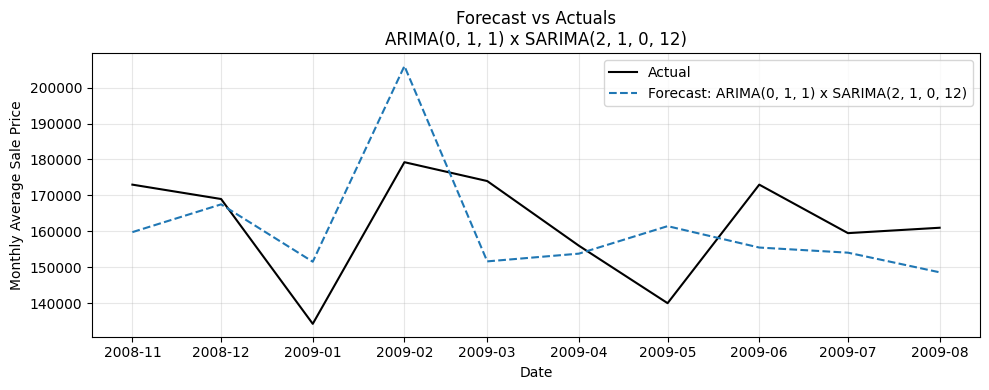

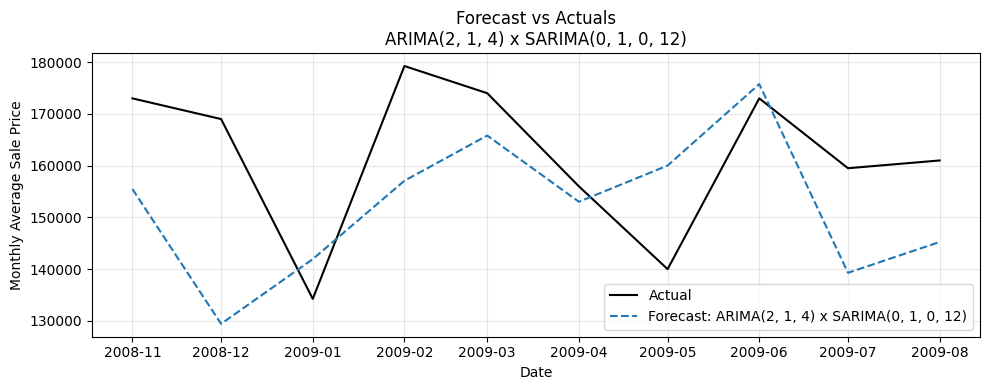

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'monthly_avg' is a DataFrame with a datetime index and a column named 'AverageSalePrice'
# Make sure the index is datetime formatted
monthly_avg.index = pd.to_datetime(monthly_avg.index)

# Split dataset
n = len(monthly_avg)
split = int(n * 0.8)
split2 = int(n * 0.6)

train = pd.concat([monthly_avg.iloc[:split2], monthly_avg.iloc[split:]])
test = monthly_avg.iloc[split2:split]

# Specify combinations
non_seasonal_orders = [
    (1,1,1), (1,1,0), (0,1,1), (0,1,0),
    (2,1,2), (2,1,0), (0,1,2), (0,1,3),
    (2,1,3), (2,1,4), (3,1,3), (3,1,4)
]

seasonal_orders = [
    (1,1,1,12), (1,1,0,12), (0,1,1,12), (0,1,0,12),
    (2,1,2,12), (2,1,0,12), (0,1,2,12), (0,1,3,12),
    (2,1,3,12), (2,1,4,12), (3,1,3,12), (3,1,4,12)
]

# Dictionary to hold results
results = {}

# Loop over combinations
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        history = train.copy()

        for t in range(len(test) - 1):  # Adjusted to avoid going out of bounds
            try:
                model = SARIMAX(history,
                                order=ns_order,
                                seasonal_order=s_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)

                forecast = model.forecast(steps=1).iloc[0]
                actual = test['AverageSalePrice'].iloc[t + 1]  # Shift actuals forward by one

                preds.append(forecast)
                actuals.append(actual)

                # Update history with current actual value
                history = pd.concat([history, test.iloc[[t]]])

            except Exception as e:
                # Skip this combination if the model fails to converge
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:  # Save only successful runs
            errors = np.array(actuals) - np.array(preds)
            var_error = np.var(errors)

            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': errors,
                'Variance of Forecast Error': var_error
            }

# Create summary DataFrame and get best two models
summary_df = pd.DataFrame([
    {'Model': name, 'Forecast Error Variance': res['Variance of Forecast Error']}
    for name, res in results.items()
]).sort_values('Forecast Error Variance').reset_index(drop=True)

print(summary_df)

# Plot only top 2 models
for name in summary_df['Model'][:2]:
    res = results[name]
    x = test.index[1:len(res['Actuals'])+1]  # Adjust x to match shifted actuals
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])

    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
